In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import scanpy as sc,anndata as ad
import squidpy as sq
import os
import re
import sys
from glob import glob
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [3]:
def combined_csv(directory, filter_fraction=None, knn=None):
    csv_files = glob(os.path.join(directory, '*.csv'))

    # Read and combine all CSVs
    dataframes = [pd.read_csv(file) for file in csv_files]
    combined_df = pd.concat(dataframes, ignore_index=True)

    # Filter for desired methods
    methods = [
        'uniform', 'leverage', 'leverage_pca', 'rasp_leverage',
        'scsampler_coord', 'scsampler_transcriptomic', 'rasp_scsampler',
        'geo_coords', 'geo_transcriptomic', 'rasp_geo'
    ]
    combined_df = combined_df[combined_df['method'].isin(methods)]

    # Apply filters
    if filter_fraction is not None:
        combined_df = combined_df[combined_df['fraction'] == filter_fraction]

    if knn is not None:
        combined_df = combined_df[combined_df['knn_for_neighborhood_analysis'] == knn]

    return combined_df

def summarize_metrics_by_method(df,dataset = 'none specified',fraction = 0.1):
    """
    Summarizes selected metrics grouped by the 'method' column.

    Returns a DataFrame with:
    - One row per method
    - ari_recomputed_pca (non-null)
    - Median, 5% and 95% quantiles for transcriptomic_distance, coord_distance, pca_mean_diff
    """
    methods = df['method'].unique()
    summary = []

    for method in methods:
        group = df[df['method'] == method]

        ari = group['ari_recomputed_pca'].dropna().values
        ari_val = ari[0] if len(ari) > 0 else np.nan

        row = {
            'method': method,
            'ari_recomputed_pca': ari_val,
            'transcriptomic_distance_median': group['transcriptomic_distance'].median(),
            'transcriptomic_distance_5%': group['transcriptomic_distance'].quantile(0.05),
            'transcriptomic_distance_95%': group['transcriptomic_distance'].quantile(0.95),
            'coord_distance_median': group['coord_distance'].median(),
            'coord_distance_5%': group['coord_distance'].quantile(0.05),
            'coord_distance_95%': group['coord_distance'].quantile(0.95),
            'pca_mean_diff_median': group['pca_mean_diff'].median(),
            'pca_mean_diff_5%': group['pca_mean_diff'].quantile(0.05),
            'pca_mean_diff_95%': group['pca_mean_diff'].quantile(0.95),
            'dataset': dataset,
            'fraction': fraction
        }

        summary.append(row)

    return pd.DataFrame(summary)


def summarize_knn_by_method(df,dataset = 'none specified', fraction = 0.1):
    methods = df['method'].unique()
    summary = []

    for method in methods:
        group = df[df['method'] == method]

        

        row = {
            'method': method,
            'mse_median': group['mse'].median(),
            'mse_5%': group['mse'].quantile(0.05),
            'mse_95%':group['mse'].quantile(0.95),
            'cosine_median': group['mean_cosine_similarity'].median(),
            'cosine_5%': group['mean_cosine_similarity'].quantile(0.05),
            'cosine_95%': group['mean_cosine_similarity'].quantile(0.95),

            'jsd_median': group['mean_jsd'].median(),
            'jsd_5%': group['mean_jsd'].quantile(0.05),
            'jsd_95%': group['mean_jsd'].quantile(0.95),

            'fro_median': group['frobenius_norm'].median(),
            'fro_5%': group['frobenius_norm'].quantile(0.05),
            'fro_95%': group['frobenius_norm'].quantile(0.95),
            'dataset': dataset,
            'fraction': fraction,
            
            
        }

        summary.append(row)

    return pd.DataFrame(summary)


def plot_summary(final_metrics, final_knn, dataset = 'allen_merfish_brain',background_color = '#ffffff'): 
    sub = final_metrics[final_metrics['dataset']==dataset]
    sub_knn = final_knn[final_knn['dataset']==dataset]
    

    
        
    
    method_order = [
        'scsampler_transcriptomic',
        'geo_transcriptomic',
        'leverage_pca',
        'leverage',
        'scsampler_coord',
        'geo_coords',
        'rasp_scsampler',
        'rasp_geo',
        'rasp_leverage',
        'uniform'
    ]
    # print(sub['method'].unique())
    # print(sub[sub['method']=='uniform'])
    fig, axes = plt.subplots(1, 5, figsize=(10, 30), sharey=True)
    #fig.patch.set_facecolor(background_color)
    for ax in axes: 
        ax.set_facecolor(background_color)
	#order the plots: 
    sub_ordered = sub.set_index('method').loc[method_order].reset_index()
    sub_knn_ordered = sub_knn.set_index('method').loc[method_order].reset_index()
    sub_ordered['1-ari'] = 1- sub_ordered['ari_recomputed_pca']
    # Plot 1: ARI Recomputed PCA
    sns.barplot(
        data=sub_ordered,
        x='1-ari',
        y='method',
        hue='method',
        palette=color_dict,
        width=0.6,
        ax=axes[0],
        legend=False,order = method_order,edgecolor = 'black',linewidth = 2
    )
    axes[0].set_title('1 - ARI')
    axes[0].set_xlabel('1-ARI')
    axes[0].set_ylabel('')
    axes[0].set_yticklabels([])
    axes[0].grid(True, axis='x', alpha=0.5)

	# Plot 2: Transcriptomic Distance
    
    
    sns.barplot(
        data=sub_ordered,
        x='transcriptomic_distance_median',
        y='method',
        hue='method',
        palette=color_dict,
        width=0.6,
        ax=axes[1],
        legend=False,
        errorbar=None,order = method_order,
        err_kws={'linewidth': 1.5},edgecolor = 'black',linewidth = 2
    )
    
    axes[1].errorbar(
        sub_ordered['transcriptomic_distance_median'],
        range(len(sub_ordered)),
        xerr=[sub_ordered['transcriptomic_distance_median'] - sub_ordered['transcriptomic_distance_5%'],
              sub_ordered['transcriptomic_distance_95%'] - sub_ordered['transcriptomic_distance_median']],
        fmt='none',
        ecolor='black',
        capsize=3,
        elinewidth=2,
        capthick=2,
    )
    
    axes[1].set_title('Transcriptomic Hausdorff Distance')
    axes[1].set_xlabel('Distance')
    axes[1].set_ylabel('')
    axes[1].set_yticklabels([])
    axes[1].grid(True, axis='x', alpha=0.5)
    
    # Plot 3: Coord Distance
    lower_coord = sub['coord_distance_5%']
    upper_coord = sub['coord_distance_95%'] 
    
    sns.barplot(
        data=sub_ordered,
        x='coord_distance_median',
        y='method',
        hue='method',
        palette=color_dict,
        width=0.6,
        ax=axes[2],
        legend=False,
        errorbar=None,order = method_order,
        err_kws={'linewidth': 1.5},edgecolor = 'black',linewidth = 2
    )
    
    axes[2].errorbar(
        sub_ordered['coord_distance_median'],
        range(len(sub_ordered)),
        xerr=[sub_ordered['coord_distance_median']-sub_ordered['coord_distance_5%'],
             sub_ordered['coord_distance_95%']-sub_ordered['coord_distance_median']],
        fmt='none',
        ecolor='black',
        capsize=3,
        elinewidth=2,
        capthick=2
    )
    
    axes[2].set_title('Coordinate Hausdorff Distance')
    axes[2].set_xlabel('Distance')
    axes[2].set_ylabel('')
    axes[2].set_yticks(range(len(method_order)))
    axes[2].set_yticklabels(method_order)
    axes[2].grid(True, axis='x', alpha=0.5)
    
    
    
    #plot 4: pca difference 
    lower_pca =  sub['pca_mean_diff_5%']
    upper_pca = sub['pca_mean_diff_95%'] 
    
    sns.barplot(
        data=sub_ordered,
        x='pca_mean_diff_median',
        y='method',
        hue='method',
        palette=color_dict,
        width=0.6,
        ax=axes[3],
        legend=False,
        errorbar=None,order = method_order,
        err_kws={'linewidth': 1.5},edgecolor = 'black',linewidth = 2
    )
    
    axes[3].errorbar(
        sub_ordered['pca_mean_diff_median'],
        range(len(sub_ordered)),
        xerr=[sub_ordered['pca_mean_diff_median']-sub_ordered['pca_mean_diff_5%'], 
              sub_ordered['pca_mean_diff_95%']-sub_ordered['pca_mean_diff_median']],
        fmt='none',
        ecolor='black',
        capsize=3,
        elinewidth=2,
        capthick=2,
    )
    
    axes[3].set_title('Sketch vs Full PCA')
    axes[3].set_xlabel('Difference')
    axes[3].set_ylabel('')
    axes[3].set_yticks(range(len(method_order)))
    axes[3].set_yticklabels(method_order)
    axes[3].grid(True, axis='x', alpha=0.5)
    
    
    
    
    #plot 4: local neighborhood difference 
    lower_mse = sub_knn['mse_5%']
    upper_mse= sub_knn['mse_95%'] 
    
    sns.barplot(
        data=sub_knn_ordered,
        x='mse_median',
        y='method',
        hue='method',
        palette=color_dict,
        width=0.6,
        ax=axes[4],
        legend=False,
        errorbar=None,order = method_order,
        err_kws={'linewidth': 1.5},edgecolor = 'black',linewidth = 2
    )
    
    axes[4].errorbar(
        sub_knn_ordered['mse_median'],
        range(len(sub_knn_ordered)),
        xerr=[sub_knn_ordered['mse_median']-sub_knn_ordered['mse_5%'], 
             sub_knn_ordered['mse_95%']-sub_knn_ordered['mse_median']],
        fmt='none',
        ecolor='black',
        capsize=3,
        elinewidth=2,
        capthick=2,
    )
    
    axes[4].set_title('Local distortion')
    axes[4].set_xlabel('mse')
    axes[4].set_ylabel('')
    axes[4].set_yticks(range(len(method_order)))
    axes[4].set_yticklabels(method_order)
    axes[4].grid(True, axis='x', alpha=0.5)

    
    
    
    
    
    plt.tight_layout()
    plt.show()
    
    return fig


    

In [82]:
#lets first create 10% summaries for all the datasets individually. 


In [36]:
dataset = "xenium_lung"
metrics_directory = '/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/sketching_test/combined_metrics'
knn_directory = '/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/sketching_test/knn_neighborhood_analysis'


from glob import glob
#now for the line plots: 
#first get the metric csvs 

# Use glob to find all .csv files in the specified directory
csv_files = glob(os.path.join(metrics_directory, '*.csv'))

# Initiate an empty list to store DataFrames
dataframes = []

# Iterate over each file path in the list of CSV files
for file in csv_files:
    # Read each CSV file into a DataFrame
    df = pd.read_csv(file)
    # filename = os.path.basename(file)
    # if filename.startswith("normal_methods"):
    #     df = df[df['method']!= 'uniform']
    #     df = df[df['method']!='leverage']
    #     df['knn_for_neighborhood_analysis'] = df['knn']
    # Append the DataFrame to the list
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
metrics_df = pd.concat(dataframes, ignore_index=True)

#read in the specific knn neighborhood analysis file: 
csv_files = glob(os.path.join(knn_directory, '*.csv'))

# Initiate an empty list to store DataFrames
dataframes = []

# Iterate over each file path in the list of CSV files
for file in csv_files:
    # Read each CSV file into a DataFrame
    df = pd.read_csv(file)
    # filename = os.path.basename(file)
    # if filename.startswith("normal_methods"):
    #     df = df[df['method']!= 'uniform']
    #     #df = df[df['method']!='leverage']
    #     df['knn_for_neighborhood_analysis'] = df['knn']
    # Append the DataFrame to the list
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
knn_df = pd.concat(dataframes, ignore_index=True)

In [37]:
#check to make sure: 
print(metrics_df['method'].unique())
print(knn_df['method'].unique())

['leverage_pca' 'geo_coords' 'geo_coord_shuffled' 'geo_transcriptomic'
 'leverage' 'scsampler_coord' 'scsampler_coord_shuffled'
 'scsampler_transcriptomic' 'uniform' 'leverage_svd'
 'leverage_svd_smoothed' 'rasp_geo' 'rasp_scsampler' 'rasp_leverage']
['geo_coords' 'geo_coord_shuffled' 'geo_transcriptomic' 'leverage'
 'scsampler_coord' 'scsampler_coord_shuffled' 'scsampler_transcriptomic'
 'uniform' 'rasp_geo' 'rasp_scsampler' 'rasp_leverage' 'leverage_svd'
 'leverage_svd_smoothed']


In [38]:
#filter the datasets to include just the methods we care about and just the sampling fraction we care about
methods = ['uniform', 'leverage', 'leverage_svd','leverage_svd_smoothed',
            'geo_coords', 'geo_transcriptomic','rasp_geo','scsampler_transcriptomic',
            'scsampler_coord','rasp_scsampler']
# Filter the dataset
metrics_sub = metrics_df[
    (metrics_df['fraction'] == 0.1) & 
    (metrics_df['method'].isin(methods))
]


knn_methods = ['uniform', 'scsampler_coord', 'scsampler_transcriptomic', 
 'geo_coords', 'geo_transcriptomic',  'leverage', 'rasp_geo',
 'rasp_scsampler',  'leverage_svd', 'leverage_svd_smoothed']

knn_sub = knn_df[
    (knn_df['fraction']==0.1)&
    (knn_df['method'].isin(knn_methods)&(knn_df['knn_for_neighborhood_analysis']==10))]

In [39]:
#check that the subsetting worked: 
print(metrics_sub['method'].unique())
print(knn_sub['method'].unique())

['geo_coords' 'geo_transcriptomic' 'leverage' 'scsampler_coord'
 'scsampler_transcriptomic' 'uniform' 'rasp_geo' 'rasp_scsampler'
 'leverage_svd' 'leverage_svd_smoothed']
['rasp_geo' 'rasp_scsampler' 'leverage_svd' 'leverage_svd_smoothed'
 'geo_coords' 'geo_transcriptomic' 'leverage' 'scsampler_coord'
 'scsampler_transcriptomic' 'uniform']


In [40]:
metric_cols = ['transcriptomic_distance', 'coord_distance', 'pca_mean_diff', 'ari_recomputed_pca']
knn_col = 'mse'

# Group and calculate means for metrics_sub
metrics_grouped = (metrics_sub.groupby('method')[metric_cols]
                   .mean()
                   .reset_index())

# For knn_sub
knn_grouped = (knn_sub.groupby('method')[[knn_col]]
               .mean()
               .reset_index())

In [41]:
all_metrics = ['transcriptomic_distance', 'coord_distance', 'pca_mean_diff', 'ari_recomputed_pca']
# Here, for overall_spatial_rank, pick which you want to sum; let's use all except pca_mean_diff for illustration:
spatial_metrics = ['transcriptomic_distance', 'coord_distance', 'ari_recomputed_pca']

def rank_metrics(group):
    group = group.copy()
    for col in all_metrics:
        if col == 'ari_recomputed_pca':
            group[col + '_rank'] = group[col].rank(ascending=False, method='min')  # Higher is better
        else:
            group[col + '_rank'] = group[col].rank(ascending=True, method='min')   # Lower is better
    group['overall_spatial_rank'] = group[[col + '_rank' for col in spatial_metrics]].sum(axis=1)
    return group

def rank_knn(group):
    group = group.copy()
    group['mse_rank'] = group['mse'].rank(ascending=True, method='min')
    return group

# Apply
metrics_ranked = rank_metrics(metrics_grouped)
knn_ranked = rank_knn(knn_grouped)

#Concat 
summary = pd.concat([metrics_ranked, knn_ranked[['mse','mse_rank']]],axis = 1)

In [139]:
summary.method.unique()

array(['geo_coords', 'geo_transcriptomic', 'leverage', 'leverage_svd',
       'leverage_svd_smoothed', 'rasp_geo', 'rasp_scsampler',
       'scsampler_coods', 'scsampler_transcriptomic', 'uniform'],
      dtype=object)

In [42]:
summary

,method,transcriptomic_distance,coord_distance,pca_mean_diff,ari_recomputed_pca,transcriptomic_distance_rank,coord_distance_rank,pca_mean_diff_rank,ari_recomputed_pca_rank,overall_spatial_rank,mse,mse_rank
0,geo_coords,7.928280,56.053932,2.730387,0.776800,4.0,1.0,3.0,1.0,6.0,0.014819,8.0
1,geo_transcriptomic,8.005768,143.391236,4.152475,0.496649,10.0,8.0,8.0,8.0,26.0,0.015133,9.0
2,leverage,7.929434,150.162624,2.536941,0.545817,5.0,9.0,2.0,6.0,20.0,0.014433,5.0
3,leverage_svd,7.936118,138.964367,3.339148,0.647166,6.0,7.0,5.0,4.0,17.0,0.014421,3.0
4,leverage_svd_smoothed,7.918713,130.997121,3.645655,0.641903,1.0,4.0,6.0,5.0,10.0,0.014424,4.0
5,rasp_geo,7.959006,133.878379,4.117320,0.514200,7.0,5.0,7.0,7.0,19.0,0.015220,10.0
6,rasp_scsampler,7.967424,121.296259,4.257145,0.444036,8.0,3.0,9.0,10.0,21.0,0.014636,6.0
7,scsampler_coord,7.922291,89.253617,2.740328,0.743062,3.0,2.0,4.0,2.0,7.0,0.013955,1.0
8,scsampler_transcriptomic,7.992154,151.668321,4.597859,0.487275,9.0,10.0,10.0,9.0,28.0,0.014651,7.0
9,uniform,7.922019,134.499894,2.174566,0.708073,2.0,6.0,1.0,3.0,11.0,0.014388,2.0


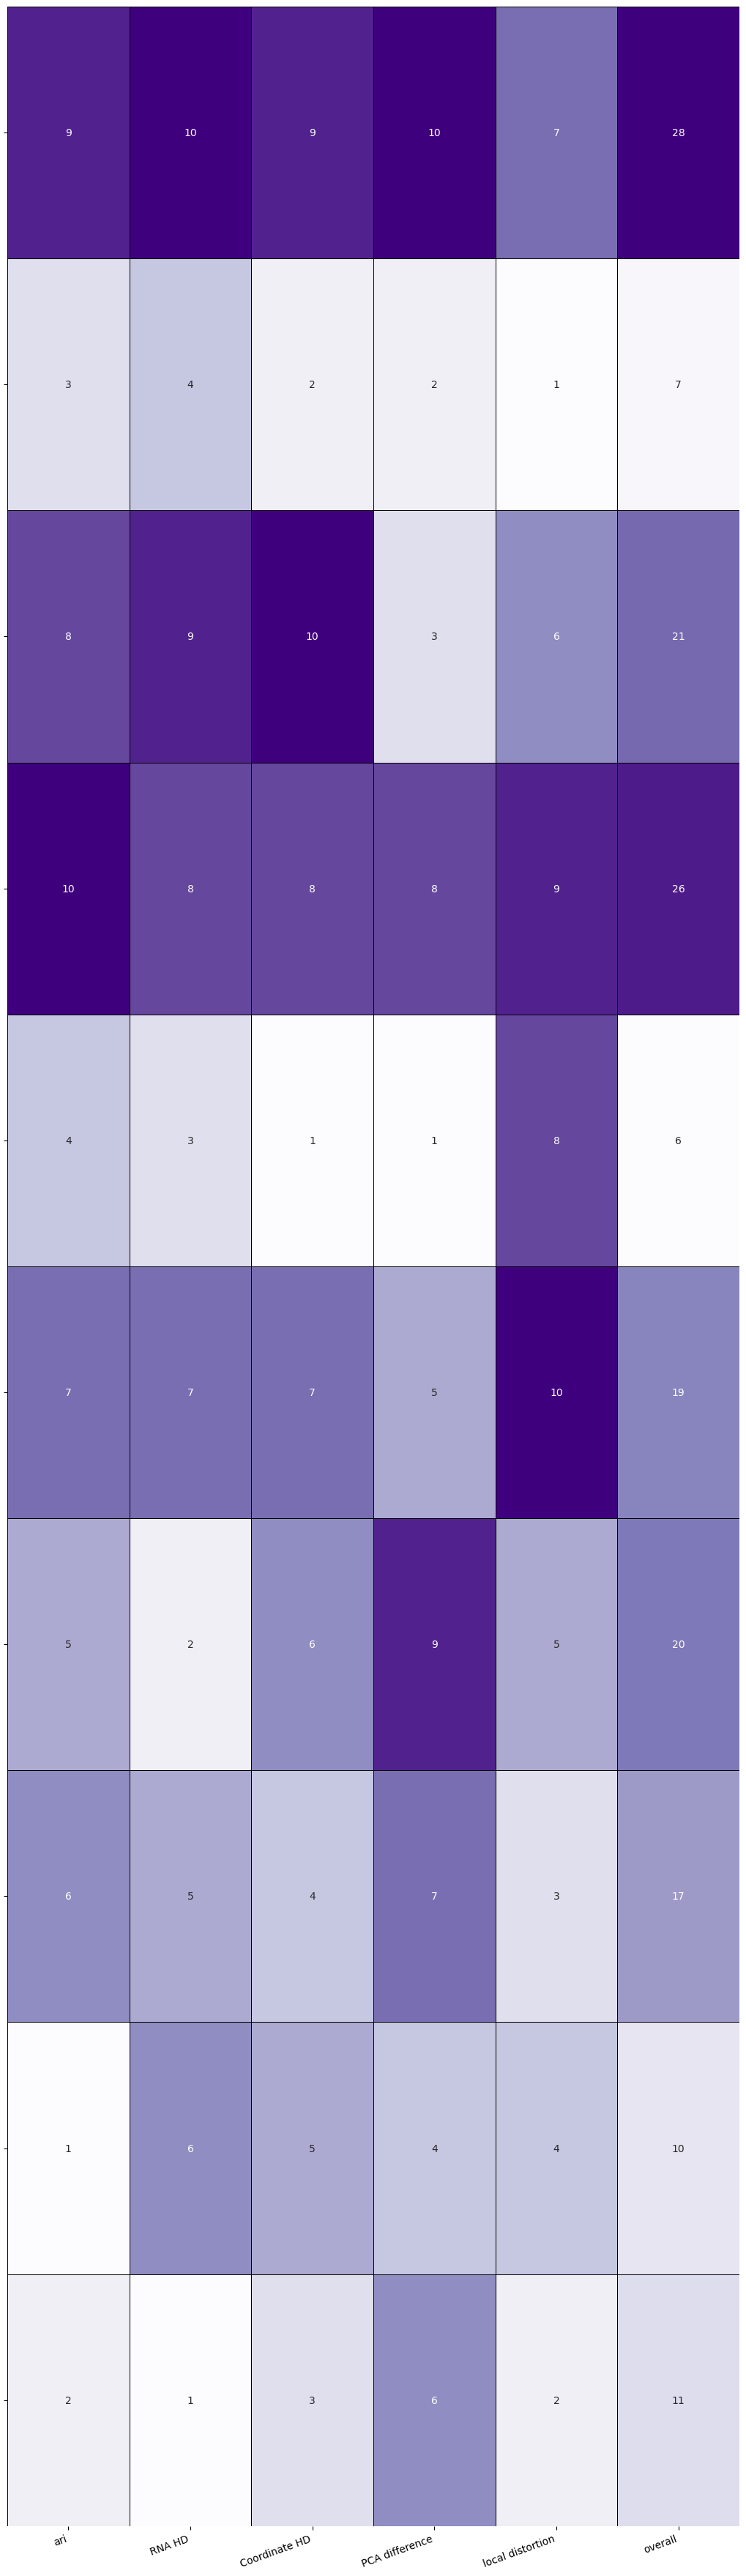

In [43]:
new_rc_params = {'text.usetex': False, "svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)



metrics = [
    'ari_recomputed_pca_rank',              # higher is better
    'transcriptomic_distance_rank',  # lower is better
    'coord_distance_rank',           # lower is better
    'pca_mean_diff_rank',            # lower is better
    'mse_rank'                       # lower is better
] 

method_order = [
    'scsampler_transcriptomic',
    'scsampler_coord',
    'rasp_scsampler',
    'geo_transcriptomic',
    'geo_coords',
    'rasp_geo',
    'leverage',
    'leverage_svd',
    'leverage_svd_smoothed',
    'uniform'
]
column_order = [
    'transcriptomic_distance_rank',
    'pca_mean_diff_rank',
    'ari_recomputed_pca_rank',
    'coord_distance_rank',
    'mse_rank',
    'overall_spatial_rank']

x_tick_labels = [
    'ari',
    'RNA HD',
    'Coordinate HD',
    'PCA difference',
    'local distortion',
    'overall'
]


metrics_to_plot = metrics + ['overall_spatial_rank']


# Set method as categorical for custom order
summary['method'] = pd.Categorical(summary['method'], categories=method_order, ordered=True)
# Set index and sort
#summary = summary.set_index('method').loc[method_order].reset_index()
summary = summary.set_index('method').reindex(method_order).reset_index()
summary[metrics_to_plot] = summary[metrics_to_plot].replace(0, np.nan)
summary = summary[column_order]


#sub = sub[metrics_to_plot]


palettes = [
    "Greys", "Purples","Blues","Greens","Oranges","Reds"
]
# Number of columns to plot
n_cols = len(column_order)
fig = plt.figure(figsize=(10, 35))
#fig = plt.figure(figsize=(2*n_cols, 8))
gs = gridspec.GridSpec(1, n_cols, wspace=0)  # no horiz. space

axes = []
for i, (col, palette) in enumerate(zip(column_order, palettes)):
    ax = plt.subplot(gs[0, i], sharey=axes[0] if axes else None)
    # DataFrame must be 2D for heatmap: pick single column and make sure it's DataFrame not Series
    data = summary[[col]]
    sns.heatmap(
        data, 
        annot=True, 
        fmt=".0f", 
        cmap='Purples',
        cbar=False,
        ax=ax,
        linewidths=0.5,
        linecolor='black'
    )
    ax.set_xticklabels([x_tick_labels[i]], rotation=20, ha='right')
    if i > 0:
        ax.set_yticklabels([])
        
        ax.set_ylabel('')
        ax.tick_params(axis='y', left=False)
    else:
        ax.tick_params(axis='y', left=True)
        ax.set_ylabel('Method')
    axes.append(ax)
    # Remove y-axis label except first one
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    

plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.show()

fig.savefig(f'/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/plots/temp/{dataset}_rank_heatmap_ordered_by_algorithm.svg', 
            format='svg', dpi=300)

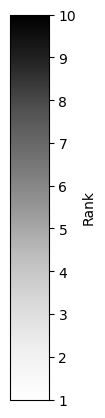

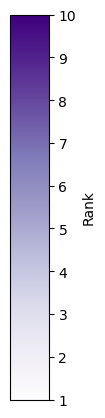

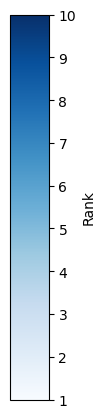

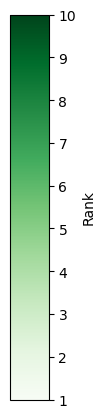

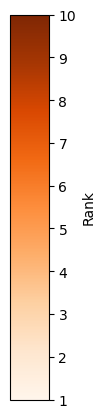

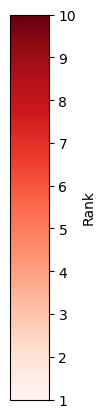

In [222]:
palettes = [
    "Greys", "Purples","Blues","Greens","Oranges","Reds"
]

for palette in palettes: 

    new_rc_params = {'text.usetex': False, "svg.fonttype": 'none'}
    mpl.rcParams.update(new_rc_params)
    
    # Create the colorbar separately
    norm = mcolors.Normalize(vmin=1, vmax=10)
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])  # Only needed for older versions of Matplotlib
    
    # Now plot the colorbar
    fig_colorbar, ax_colorbar = plt.subplots(figsize=(.5, 5))  # Adjust size as necessary
    cbar = plt.colorbar(sm, cax=ax_colorbar)
    cbar.set_label('Rank')  # You can set the label for the colorbar
    plt.savefig(f'/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/plots/temp/{palette}_colormap.svg', 
                dpi=300, bbox_inches='tight',format = 'svg')
    plt.show()